In [1]:
import sys
import os
import glob
import pandas as pd

import numpy as np
import sklearn
print (sklearn.__version__)

from sklearn import linear_model
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.externals import joblib
import seaborn as sns

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.svm import  SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.externals.six import StringIO

from sklearn.ensemble import RandomForestClassifier,VotingClassifier,AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

0.19.1


In [2]:
# ディレクトリ名
input_dir = ur"C:/Users/mirait/wk/git/input/"
output_dir = ur"C:/Users/mirait/wk/git/output/"

In [3]:
# 訓練データを読み込む
train_path = input_dir + ur"train.csv"
train_data = pd.read_csv(train_path, encoding="cp932",low_memory=False)
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# テストデータを読み込む
test_path = input_dir + ur"test.csv"
test_data = pd.read_csv(test_path, encoding="cp932",low_memory=False)
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
print "訓練データ：レコード長", len(train_data)
print "訓練データ：カラム数",len(train_data.columns)
print "テストデータ：レコード長", len(test_data)
print "テストデータ：カラム数",len(test_data.columns)

訓練データ：レコード長 891
訓練データ：カラム数 12
テストデータ：レコード長 418
テストデータ：カラム数 11


In [6]:
# 訓練+テストを結合
merge_arr = [train_data, test_data]

In [7]:
# 分析に生かすために項目の特徴量を取得
def feature(df):
    
    df_feature = pd.DataFrame()
    
    for i in (range(len(df.columns))):
        tmp = pd.DataFrame()
        tmp = df.iloc[:, [i]]
        
        selList = list()
        record_cn = len(tmp) #レコード数
        column_name = tmp.columns[0] #カラム名
        value_type_cn = len(pd.value_counts(tmp.values.flatten())) #値の種類数(NAはカウント外)
        NA_cn = tmp.isnull().sum().values[0] #NA件数

        feature_list = list([record_cn, column_name, value_type_cn, NA_cn])
        now_column = pd.DataFrame(feature_list).T
        #print res1
        
        df_feature = pd.concat([df_feature, now_column], ignore_index=True)
    
    df_feature.columns = [u'レコード数', u'カラム名', 'v_count', u'NA件数']
        
    col_names = list(df_feature.columns)
    df_feature = df_feature.loc[:, col_names]

    return df_feature

In [8]:
# 訓練データの特徴量
feature_train = feature(train_data)
print len(feature_train)

12


In [9]:
output_feature_train = os.path.join(output_dir, "column_feature_train.csv")
feature_train.to_csv(output_feature_train, encoding="cp932",index=False)

In [10]:
# テストデータの特徴量
feature_test = feature(test_data)
print len(feature_test)

11


In [11]:
output_feature_test = os.path.join(output_dir, "column_feature_test.csv")
feature_test.to_csv(output_feature_test, encoding="cp932",index=False)

In [12]:
# 欠損値があるカラムを取得
null_columns = [col for col in train_data.columns if train_data[col].isnull().any()]
null_columns

[u'Age', u'Cabin', u'Embarked']

In [13]:
# 「Cabin」の欠損値を埋める
train_data['Cabin'] = pd.Series([i[0] if pd.notnull(i) else 'X' for i in train_data['Cabin'] ])
train_data['Cabin'].replace('T','X',inplace=True)    # テストデータには"T"がないため、欠損値ど同義と捉え"X"に置換
test_data['Cabin'] = pd.Series([i[0] if pd.notnull(i) else 'X' for i in test_data['Cabin'] ])

X    688
C     59
B     47
D     33
E     32
A     15
F     13
G      4
Name: Cabin, dtype: int64


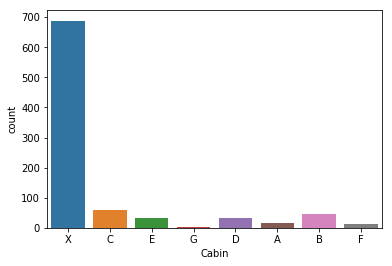

In [14]:
# 「Cabin」のデータ分布を視覚化
print(train_data.Cabin.value_counts())
sns.countplot('Cabin', data=train_data)

In [15]:
# 人物名の敬称を取得
for data in merge_arr:
    data['Title'] = data.Name.str.split(', ',expand=True)[1].str.split('. ',expand=True)[0]
    title_cnt = data.Title.value_counts()<10
    data.Title = data.Title.apply(lambda x: x if title_cnt[x]==False else 'Misc')

In [16]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,X,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,X,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,X,S,Mr


In [17]:
print title_cnt.head()
print data.head()

Mr        False
Miss      False
Mrs       False
Master    False
Col        True
Name: Title, dtype: bool
   PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked Title  
0  34.5      0      0   330911   7.8292     X        Q    Mr  
1  47.0      1      0   363272   7.0000     X        S   Mrs  
2  62.0      0      0   240276   9.6875     X        Q    Mr  
3  27.0      0      0   315154   8.6625     X        S    Mr  
4  22.0      1      1  3101298  12.2875     X        S   Mrs  


In [18]:
# 年齢の欠損値埋め
# チケットクラス、敬称、性別から年齢の平均値をそれぞれ取得して埋める
# 単純に平均値で埋めるのではなく、年齢と相関関係が高いと推測される項目から取得 (先に項目間の相関関係を取得する必要あり)
med_age = pd.DataFrame()
def fill_age(cols):
    pclass = cols[0]
    sex = cols[1]
    age = cols[2]
    title = cols[3]
    if pd.isnull(age):
        return med_age[(med_age['Pclass']==pclass) & (med_age['Title']==title) & (med_age['Sex']==sex)]['Age']
    else:
        return age

In [19]:
for dataset in merge_arr:
    med_age = dataset.groupby(['Pclass','Title','Sex'])['Age'].median().reset_index()
    dataset['Age'] = dataset[['Pclass','Sex','Age','Title']].apply(fill_age,axis=1)
    
    # Embarkedは欠損値が2つのみのため最頻値で埋める
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace=True)
    # 世帯人数に関連する項目を追加
    dataset['FamilySize'] = dataset.SibSp+dataset.Parch+1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize']>1]=0
    # 賃金を四分割
    dataset['FareBin']=pd.qcut(dataset['Fare'],4,labels=[1,2,3,4])
    # 年齢を五分割
    dataset['AgeBin']=pd.cut(dataset['Age'],5,labels=[1,2,3,4,5])

C:\Users\mirait\Anaconda2\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\mirait\Anaconda2\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in greater_equal
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\mirait\Anaconda2\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in less_equal
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\mirait\Anaconda2\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in less_equal
  return umr_maximum(a, axis, None, out, keepdims)
C:\Users\mirait\Anaconda2\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in greater_equal
 

0    549
1    342
Name: Survived, dtype: int64


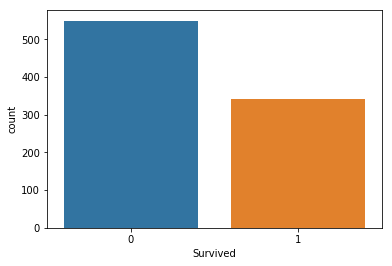

In [20]:
# 生存者数の総数を確認
print(train_data.Survived.value_counts())
sns.countplot(x='Survived',data=train_data)
plt.show()

Sex
female    233
male      109
Name: Survived, dtype: int64


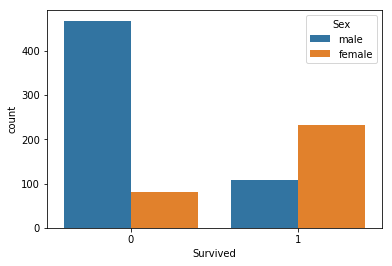

In [21]:
# 性別-生存者数
print(train_data.groupby('Sex')['Survived'].sum())
sns.countplot(x='Survived',hue='Sex',data=train_data)
plt.show()

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64


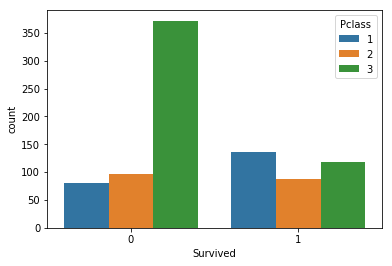

In [22]:
# チケットクラス-生存者数
print(train_data.groupby('Pclass')['Survived'].sum())
sns.countplot(x='Survived',hue='Pclass',data=train_data)
plt.show()

Title
Master     23
Misc       12
Miss      127
Mr         81
Mrs        99
Name: Survived, dtype: int64


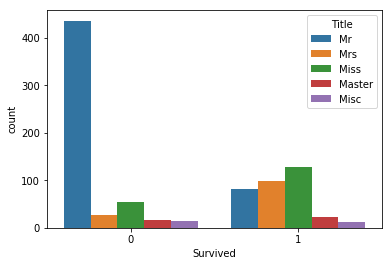

In [23]:
# 敬称-生存者数
print(train_data.groupby('Title')['Survived'].sum())
sns.countplot(x='Survived',hue='Title',data=train_data)
plt.show()

IsAlone
0    179
1    163
Name: Survived, dtype: int64


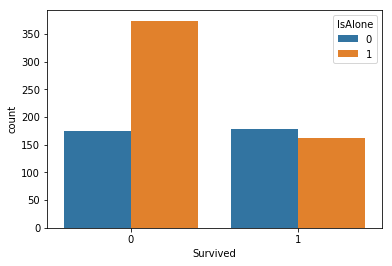

In [24]:
# 単身者-生存者数
print(train_data.groupby('IsAlone')['Survived'].sum())
sns.countplot(x='Survived',hue='IsAlone',data=train_data)
plt.show()

FamilySize
1     163
2      89
3      59
4      21
5       3
6       3
7       4
8       0
11      0
Name: Survived, dtype: int64


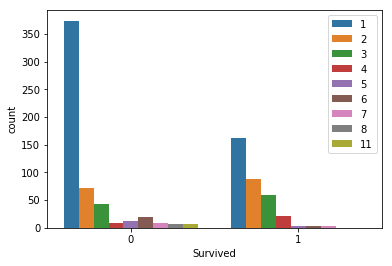

In [25]:
# 世帯人数-生存者数
print(train_data.groupby('FamilySize')['Survived'].sum())
sns.countplot(x='Survived',hue='FamilySize',data=train_data)
plt.legend(loc=1) #moving the legned to the right
plt.show()

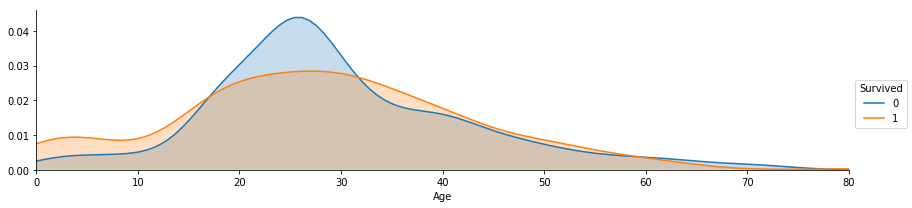

In [26]:
train_data.Age=train_data.Age.astype(int)
# 年齢-生存者数でプロット
ageplt = sns.FacetGrid(train_data,hue='Survived',aspect=4)
ageplt.map(sns.kdeplot,'Age',shade=True)
ageplt.set(xlim=(0,train_data.Age.max()))
ageplt.add_legend()
plt.show()

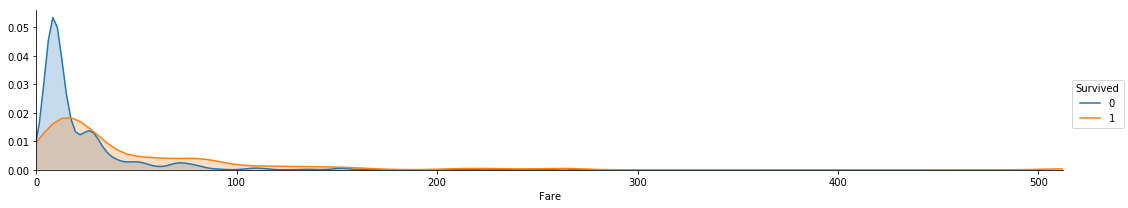

In [27]:
# 賃金-生存者数でプロット
fareplt = sns.FacetGrid(train_data,hue='Survived',aspect=5)
fareplt.map(sns.kdeplot,'Fare',shade=True)
fareplt.set(xlim=(0,train_data.Fare.max()))
fareplt.add_legend()
plt.show()

In [28]:
train_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
PassengerId,1.000000,-0.005007,-0.035144,0.042740,-0.057527,-0.001652,0.012658,-0.040143,0.057462
Survived,-0.005007,1.000000,-0.338481,-0.061909,-0.035322,0.081629,0.257307,0.016639,-0.203367
Pclass,-0.035144,-0.338481,1.000000,-0.416137,0.083081,0.018443,-0.549500,0.065997,0.135207
Age,0.042740,-0.061909,-0.416137,1.000000,-0.270292,-0.184922,0.121983,-0.277119,0.178680
SibSp,-0.057527,-0.035322,0.083081,-0.270292,1.000000,0.414838,0.159651,0.890712,-0.584471
Parch,-0.001652,0.081629,0.018443,-0.184922,0.414838,1.000000,0.216225,0.783111,-0.583398
Fare,0.012658,0.257307,-0.549500,0.121983,0.159651,0.216225,1.000000,0.217138,-0.271832
FamilySize,-0.040143,0.016639,0.065997,-0.277119,0.890712,0.783111,0.217138,1.000000,-0.690922
IsAlone,0.057462,-0.203367,0.135207,0.178680,-0.584471,-0.583398,-0.271832,-0.690922,1.000000


In [29]:
# 一意の値と推測できる項目は削除　（'PassengerId','Ticket','Name'）
# 新規項目追加時に使用した項目は、新規項目で代替可能なため削除　（'Fare','Age','SibSp','Parch'）
train_data.drop(['PassengerId','Ticket','Name','Fare','Age','SibSp','Parch'],axis=1,inplace=True)
test_data.drop(['Ticket','Name','Fare','Age','Parch','SibSp'],axis=1,inplace=True)
train_data.head()

,Survived,Pclass,Sex,Cabin,Embarked,Title,FamilySize,IsAlone,FareBin,AgeBin
0,0,3,male,X,S,Mr,2,0,1,2
1,1,1,female,C,C,Mrs,2,0,4,3
2,1,3,female,X,S,Miss,1,1,2,2
3,1,1,female,C,S,Mrs,2,0,4,3
4,0,3,male,X,S,Mr,1,1,2,3


In [30]:
# ダミー変数化
train_dum = pd.get_dummies(train_data, columns=['Sex','Embarked','Pclass','Title','AgeBin','FareBin','Cabin'],drop_first=True)
test_dum = pd.get_dummies(test_data, columns=['Sex','Embarked','Pclass','Title','AgeBin','FareBin','Cabin'],drop_first=True)

In [31]:
train_dum.corr()['Survived']

Survived      1.000000
FamilySize    0.016639
IsAlone      -0.203367
Sex_male     -0.543351
Embarked_Q    0.003650
Embarked_S   -0.149683
Pclass_2      0.093349
Pclass_3     -0.322308
Title_Misc    0.022030
Title_Miss    0.327093
Title_Mr     -0.549199
Title_Mrs     0.339040
AgeBin_2     -0.107068
AgeBin_3      0.032801
AgeBin_4      0.026859
AgeBin_5     -0.067344
FareBin_2    -0.095648
FareBin_3     0.084239
FareBin_4     0.233638
Cabin_B       0.175095
Cabin_C       0.114652
Cabin_D       0.150716
Cabin_E       0.145321
Cabin_F       0.057935
Cabin_G       0.016040
Cabin_X      -0.319572
Name: Survived, dtype: float64

In [32]:
train_dum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
Survived      891 non-null int64
FamilySize    891 non-null int64
IsAlone       891 non-null int64
Sex_male      891 non-null uint8
Embarked_Q    891 non-null uint8
Embarked_S    891 non-null uint8
Pclass_2      891 non-null uint8
Pclass_3      891 non-null uint8
Title_Misc    891 non-null uint8
Title_Miss    891 non-null uint8
Title_Mr      891 non-null uint8
Title_Mrs     891 non-null uint8
AgeBin_2      891 non-null uint8
AgeBin_3      891 non-null uint8
AgeBin_4      891 non-null uint8
AgeBin_5      891 non-null uint8
FareBin_2     891 non-null uint8
FareBin_3     891 non-null uint8
FareBin_4     891 non-null uint8
Cabin_B       891 non-null uint8
Cabin_C       891 non-null uint8
Cabin_D       891 non-null uint8
Cabin_E       891 non-null uint8
Cabin_F       891 non-null uint8
Cabin_G       891 non-null uint8
Cabin_X       891 non-null uint8
dtypes: int64(3), uint8(23)
memory us

In [33]:
# 欠損値の処理
tmp = train_dum.copy()
print len(tmp)
tmp01 = tmp.dropna()
print len(tmp01),":NA行数 ",(len(tmp)-len(tmp01))
tmp02 = tmp01.replace([np.inf,-np.inf],np.nan)    #infの置換
tmp03 = tmp02.dropna().reset_index(drop =True)
print len(tmp03),":inf行数 ",(len(tmp02)-len(tmp03))

891
891 :NA行数  0
891 :inf行数  0


In [34]:
# 乗客番号は出力に用いるため退避し削除
PassengerId = test_data['PassengerId']
test_dum.drop(labels=['PassengerId'],inplace=True,axis=1)

In [35]:
# 説明変数、目的変数への分割
X = tmp03.drop(columns = {u"Survived"},axis =1)
y = tmp03.loc[:,[u"Survived"]]

print len(X.columns)
print len(X)

25
891


In [36]:
# データ分割
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=.20, random_state=1)

In [37]:
# グリッドサーチ
def grid(x, y, clf, grid_param, cv):
    
    # パラメータ探索
    gs = GridSearchCV(clf, grid_param, cv=cv)
    gs.fit(x, y)
    
    # グリッドサーチの結果を出力
    result = pd.DataFrame(gs.grid_scores_)
    result = result.iloc[:,[0,1]]
    print gs.best_params_
    
    return result, gs.best_params_

In [38]:
# モデル構築

In [39]:
# SGD

In [40]:
# SGD (回帰係数、適合率など評価)
def sgd(X_train, y_train, X_test, y_test, param):
    
    # モデル構築
#   clf =linear_model.SGDClassifier(loss='log', penalty='elasticnet', random_state=0, class_weight='balanced',
#                                     alpha = param['alpha'] , l1_ratio = param['l1_ratio'], max_iter=500)
    clf =linear_model.SGDClassifier(loss='log', penalty='elasticnet', class_weight='balanced',
                                    alpha = param['alpha'] , l1_ratio = param['l1_ratio'], max_iter=500)
    clf.fit(X_train,y_train)
    
    # モデル評価を出力
    print "score:", clf.score(X_test,y_test)
    print "confusion_matrix:"
    print confusion_matrix(y_test, clf.predict(X_test))

    # 回帰係数を出力
    coeff_df = pd.DataFrame([X_train.columns,  clf.coef_[0]]).T
    coeff_df.columns = ["col_name","coef"] 
    coeff_df["coef_abs"] = abs(coeff_df["coef"] )
    coeff_sort = coeff_df.sort_values(by="coef_abs", ascending=False).reset_index(drop=True)


    print ""
    print "回帰係数の総数",len(coeff_sort)
    coeff_sort.coef =coeff_sort.coef.astype(np.float)
    print "回帰係数 0の数",len(coeff_sort.query('coef == 0'))
    print "回帰係数 0以外の数",len(coeff_sort.query('coef != 0'))
    

    # 適合率、再現率、閾値をそれぞれ出力
    print ""
    precision, recall, threshold = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1] )#
    print ""
    print (classification_report(y_test, clf.predict(X_test)))
    
    print ""
    prob = clf.predict_proba(X_test)[:,1]
    fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_test,prob)
    print "auc", round(sklearn.metrics.auc(fpr,tpr),4)
    
    # ROC曲線
    plt.plot(fpr, tpr)
    plt.title("ROC curve")
    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    #plt.show()
    
    return clf, coeff_sort

In [41]:
# 交差検定の実行回数
cv  = 10

In [42]:
# SGDのパラメータリスト
sgd_param = [{'alpha': [0.001, 0.0001, 0.00001],'l1_ratio': [0, 0.02, 0.04]}]

In [43]:
# グリッドサーチ用SGD
grid_sgd = linear_model.SGDClassifier(loss='log', penalty='elasticnet', random_state=0, class_weight='balanced',max_iter=50)

In [44]:
print grid_sgd

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=0,
       shuffle=True, tol=None, verbose=0, warm_start=False)


In [45]:
grid_result_SGD, best_param_SGD = grid(X_train, y_train, grid_sgd, sgd_param, cv)

C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'alpha': 0.001, 'l1_ratio': 0.02}


C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [46]:
# グリッドサーチの探索結果を出力
output_grid = os.path.join(output_dir, "grid_SGD.csv")
grid_result_SGD.to_csv(output_grid, encoding="cp932", index=False)

score: 0.7877094972067039
confusion_matrix:
[[85 21]
 [17 56]]

回帰係数の総数 25
回帰係数 0の数 0
回帰係数 0以外の数 25


             precision    recall  f1-score   support

          0       0.83      0.80      0.82       106
          1       0.73      0.77      0.75        73

avg / total       0.79      0.79      0.79       179


auc 0.8332


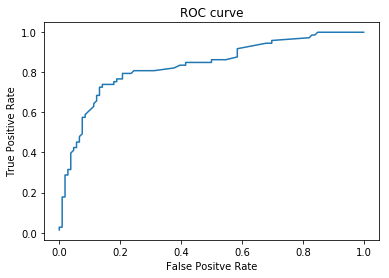

In [47]:
# 最適パラメータでモデル構築
clf_SGD, result = sgd(X_train, y_train, X_test, y_test, best_param_SGD)

In [48]:
print(clf_SGD.score(X_train,y_train))

0.8441011235955056


In [49]:
# 交差検証
cross_scores = cross_val_score(clf_SGD, X_test, (np.array(y_test.iloc[:,0].values.flatten())), cv=10)
print cross_scores
print ("Accuracy: %0.2f" % (cross_scores.mean()))

[0.84210526 0.57894737 0.63157895 0.61111111 0.88888889 0.77777778
 0.76470588 0.82352941 0.82352941 1.        ]
Accuracy: 0.77


In [50]:
# 決定木

In [51]:
def decisionTree (x_train, x_test, y_train, y_test):
    
    # モデル構築
#     clf = DecisionTreeClassifier(max_depth=5, random_state=0, class_weight='balanced')
    clf = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
    clf.fit(X_train, y_train)
    
    predicted = clf.predict(x_test)
    #print "識別率：", float(sum(predicted == np.array(y_test.iloc[:,0]).T))/len(y_test)
    dot_data = StringIO()
    tree.export_graphviz(clf, out_file = dot_data, feature_names=list(x_train.columns), filled=True, rounded=True,impurity=False)
    res = dot_data.getvalue()
    res_wk = res.encode("cp932")
    dot_file = res_wk.replace("fontname=helvetica","fontname=meiryo")
    
    print "accuracy_score:", round(clf.score(x_test,y_test),4)
    print "confusion_matrix:"
    print confusion_matrix(y_test,clf.predict(x_test))
    print ""
    prob = clf.predict_proba(x_test)[:,1]
    fpr,tpr,thresholds = roc_curve(y_test,prob)
    print "auc:", round(auc(fpr,tpr),4)
    
    # 変数重要度
    column_importance = pd.DataFrame(clf.feature_importances_).T
    column_importance.columns = list(x_train.columns)
    column_importance_wk = column_importance.T.reset_index(drop=False)
    column_importance_wk.columns = ["col_name","feature_importances"]
    column_importance_sort = column_importance_wk.sort_values(by="feature_importances", ascending=False).reset_index(drop=True)

    return clf, dot_file, column_importance_sort

In [52]:
clf_dt, dot_file, dt_importance = decisionTree(X_train, X_test, y_train, y_test)

accuracy_score: 0.7877
confusion_matrix:
[[88 18]
 [20 53]]

auc: 0.8051


In [53]:
print(clf_dt.score(X_train,y_train))

0.8553370786516854


In [54]:
#ファイル出力
f = open('decisionTree.dot','w')
f.write(dot_file)
f.close()

In [55]:
# ランダムフォレスト

In [56]:
def randomforest(x_train, x_test, y_train, y_test, param):
    clf = RandomForestClassifier(n_estimators = param['n_estimators'], max_depth = param['max_depth'], 
                                 random_state=0, class_weight='balanced')
    clf.fit(x_train, y_train)
    prob = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    
    print "accuracy_score:",round(clf.score(x_test,y_test),4)
    print "auc:", round(auc(fpr,tpr),4)
    print "confusion_matrix:"
    print confusion_matrix(y_test,clf.predict(x_test))
    
    # ROC曲線を出力
    plt.plot(fpr, tpr)
    plt.title("ROC curve")
    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    
    return clf

In [57]:
# 特徴量を順位付け
def get_feature_importance(x, clf):
    col_name = pd.DataFrame(x.columns)
    fi = pd.DataFrame(clf.feature_importances_)
    df_wk = pd.concat([col_name, fi],axis=1)
    df_wk.columns = ["col_name","feature_importance"]
    importance_list = df_wk.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
    
    return importance_list 

In [58]:
# ランダムフォレストのパラメータリスト
depth_range = range(2, 13, 1)
rf_parameter = [{'n_estimators':[30, 50, 70], 'max_depth':depth_range}]

In [59]:
# グリッドサーチ用ランダムフォレスト
grid_rf = RandomForestClassifier(random_state=0, class_weight='balanced')

In [60]:
# パラメータ探索　（標準化の必要がないため、説明変数は標準化前のデータを使用）
grid_result_rf, best_param_rf = grid(X_train, y_train, grid_rf, rf_parameter, cv)

C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


{'n_estimators': 50, 'max_depth': 5}


C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [61]:
# グリッドサーチの探索結果を出力
output_grid = os.path.join(output_dir, "grid_rf.csv")
grid_result_rf.to_csv(output_grid, encoding="cp932", index=False)

C:\Users\mirait\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


accuracy_score: 0.7877
auc: 0.8317
confusion_matrix:
[[89 17]
 [21 52]]


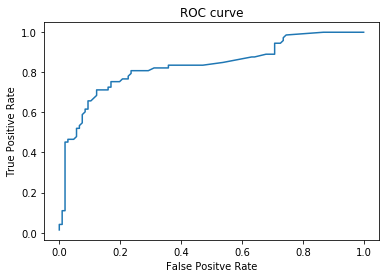

In [62]:
# 最適パラメータでモデル構築
clf_rf = randomforest(X_train, X_test, y_train, y_test, best_param_rf)

In [63]:
print(clf_rf.score(X_train,y_train))

0.8651685393258427


In [64]:
# 特徴量の順位を取得
feature_importance = get_feature_importance(X_train, clf_rf)
output_path = os.path.join(output_dir, "feature_importance.csv")
feature_importance.to_csv(output_path, encoding="cp932", index=False)

In [65]:
# LogisticRegression

In [66]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression (max_iter=100)
clf_log.fit(X_train,y_train)
ypred = clf_log.predict(X_test)
print(clf_log.score(X_train,y_train))
print(confusion_matrix(y_test,ypred))
print(classification_report(y_test,ypred))

0.8412921348314607
[[91 15]
 [19 54]]
             precision    recall  f1-score   support

          0       0.83      0.86      0.84       106
          1       0.78      0.74      0.76        73

avg / total       0.81      0.81      0.81       179



In [67]:
# GBDT

In [68]:
def gbdt(x_train, x_test, y_train, y_test, param):
    clf = GradientBoostingClassifier(n_estimators = param['n_estimators'], max_depth = param['max_depth'], 
                                 random_state=0)
    clf.fit(x_train, y_train)
    prob = clf.predict_proba(x_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, prob)
    
    print "acc:",round(clf.score(x_test,y_test),4)
    print "auc:", round(auc(fpr,tpr),4)
    print "confusion_matrix:"
    print confusion_matrix(y_test,clf.predict(x_test))
    
    # ROC曲線を出力
    plt.plot(fpr, tpr)
    plt.title("ROC curve")
    plt.xlabel("False Positve Rate")
    plt.ylabel("True Positive Rate")
    
    return clf

In [69]:
# GBDTのパラメータリスト
depth_range = range(2, 13, 1)
gbdt_parameter = [{'n_estimators':[10, 50, 100, 150], 'max_depth':depth_range}]

In [70]:
# グリッドサーチ用GBDT
# grid_gbdt = GradientBoostingClassifier(random_state=0)
grid_gbdt = GradientBoostingClassifier()

In [71]:
# パラメータ探索
grid_result_gbdt, best_param_gbdt = grid(X_train, y_train, grid_gbdt, gbdt_parameter, cv)

{'n_estimators': 50, 'max_depth': 3}


C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [72]:
# グリッドサーチの探索結果を出力
output_grid = os.path.join(output_dir, "grid_gbdt.csv")
grid_result_gbdt.to_csv(output_grid, encoding="cp932", index=False)

acc: 0.7821
auc: 0.8584
confusion_matrix:
[[97  9]
 [30 43]]


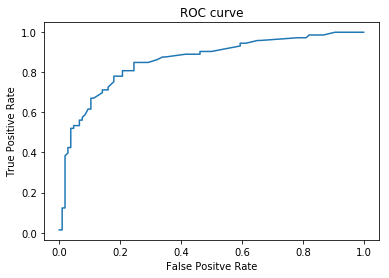

In [73]:
# 最適パラメータでモデル構築
clf_gbdt = gbdt(X_train, X_test, y_train, y_test, best_param_gbdt)

In [74]:
print(clf_gbdt.score(X_train,y_train))

0.8735955056179775


In [75]:
# モデルをエクスポート
joblib.dump(clf_gbdt, 'model_gbdt.pkl',compress=True)

['model_gbdt.pkl']

In [95]:
# 学習済モデルを取り込み
clf_voting = VotingClassifier(estimators=[('sgd',clf_SGD),('dt',clf_dt),('rf',clf_rf),('log',clf_log),('gbdt',clf_gbdt)],voting='soft',n_jobs=5)

In [96]:
clf_voting.fit(X_train, y_train)

VotingClassifier(estimators=[('sgd', SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.02,
       learning_rate='optimal', loss='log', max_iter=500, n_iter=None,
       n_jobs=1, penalty='elasticnet', power_t=0.5, random_state=None,
      ...         presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False))],
         flatten_transform=None, n_jobs=5, voting='soft', weights=None)

In [97]:
# モデルをエクスポート
joblib.dump(clf_voting, 'model_voting.pkl',compress=True)

['model_voting.pkl']

In [98]:
gen_path = input_dir + ur"gender_submission.csv"
gen_data = pd.read_csv(gen_path, encoding="cp932",low_memory=False)

In [99]:
pred1 = clf_voting.predict(test_dum)
print(confusion_matrix(gen_data.Survived,pred1))
print(classification_report(gen_data.Survived,pred1))

[[232  34]
 [  5 147]]
             precision    recall  f1-score   support

          0       0.98      0.87      0.92       266
          1       0.81      0.97      0.88       152

avg / total       0.92      0.91      0.91       418



C:\Users\mirait\Anaconda2\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [100]:
# 乗客番号と予測結果を結合
y_re = pd.Series(pred1)
# y_re = y_predict.reshape(len(y_predict),1)
result = pd.concat([PassengerId, y_re], axis=1)
result_re = result.rename(columns={0: 'Survived'})

In [101]:
print result_re

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         0
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         1
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         1
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         0
391         1283         1
392         1284         1
3

In [102]:
# 目的変数の値を確認
print "値0", len(result_re.query('Survived == 0'))
print "値1", len(result_re.query('Survived == 1'))

値0 237
値1 181


In [103]:
# 予測結果を出力
output = os.path.join(output_dir, "survived_predict.csv")
result_re.to_csv(output, encoding="cp932", index=False)

In [109]:
prediction = clf_log.predict(test_dum)
print(confusion_matrix(gen_data.Survived,prediction))
print(classification_report(gen_data.Survived,prediction))

[[244  22]
 [ 11 141]]
             precision    recall  f1-score   support

          0       0.96      0.92      0.94       266
          1       0.87      0.93      0.90       152

avg / total       0.92      0.92      0.92       418



In [112]:
# 乗客番号と予測結果を結合
y_re2 = pd.Series(prediction)
# y_re = y_predict.reshape(len(y_predict),1)
result2 = pd.concat([PassengerId, y_re2], axis=1)
result_re2 = result2.rename(columns={0: 'Survived'})

In [113]:
# 予測結果を出力
output = os.path.join(output_dir, "survived_predict_2.csv")
result_re2.to_csv(output, encoding="cp932", index=False)